In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.activations import tanh
from keras import losses
from keras.datasets import fashion_mnist

In [ ]:
import os
import glob
from IPython import display

import imageio
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_images: np.ndarray
train_labels: np.ndarray
train_images, train_labels = fashion_mnist.load_data()[0]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator():
    model = Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), use_bias=False, padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=False, padding='same'))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), activation=tanh, use_bias=False, padding='same'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

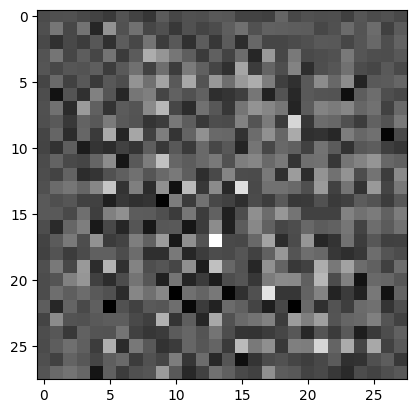

In [ ]:
generator = build_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(2))

    return model

In [ ]:
discriminator = build_discriminator()
discriminator(generated_image)

tf.Tensor([[-0.00313021  0.00235565]], shape=(1, 2), dtype=float32)


In [ ]:
cross_entropy = losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [ ]:
EPOCHS = 70
NOISE_DIM = 100
NUM_EXAMPLE_TO_GENERATE = 16

seed = tf.random.normal([NUM_EXAMPLE_TO_GENERATE, NOISE_DIM])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_imgs = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_imgs, training=True)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.title(f'Epochs: {epoch}')
    plt.show()

In [ ]:
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for imgs in dataset:
            train_step(imgs)
        
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

        if epoch % 16 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

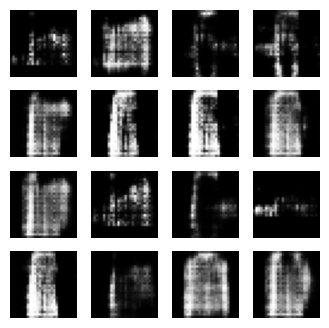

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open(f'image_at_epoch_{epoch_no}.png')

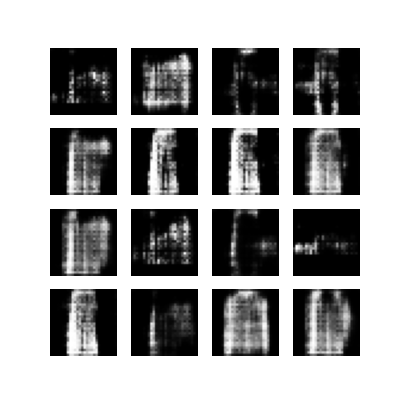

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'fashion.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)